In [ ]:
import itertools

import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import numpy as np

from qutip import * 
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = os.getcwd()  # Gets the current working directory
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$

$$
H_0 = \hbar \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)} + \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{ij} \sigma_+^{(i)} \sigma_-^{(j)} \quad \text{,} \quad J_{ij} = \frac{\alpha}{|r_i - r_j|^3}
$$

$$
H_I = \hbar D \cdot E(t)
\quad \text{,} \quad D = \mu \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} + \sigma_-^{(i)}
\quad \text{,} \quad E(t_i) \propto \Omega_{coupling} \cos(\pi (t - t_i)) \delta(t_i)
$$

### Decay operators single case
$$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$$

In [347]:
#
# Set the system parameters
#
# ENERGY LANDSCAPE, c = 1, hbar = 1
fixed_lam = 1. #
alpha     = 1. # coupling strength of the dipoles       Fine structure const?

omega_a   = 2 * np.pi / fixed_lam   # energysplitting of the atom, when ground state is set to 0
mu        = 1 * omega_a             # Dipole matrix element of each atom
omega_R   = 1 * omega_a             # Rabi freq coupling to laser field  for first 2 lasers  -> E_field_0 dot dot Dip_op, parallel

# LINBLAD OPS
gamma_0   = .1      # decay rate of the atoms
gamma_phi = .1      # dephasing rate of the atoms

# TOPOLOGY
n_chains = 1        # number of chains
n_rings  = 1        # number of rings
N_atoms  = n_chains * n_rings  # number of atoms

distance = 1.       # * fixed_lam # defining topology

# TIME EVOLUTION
t_max = 5           # Maximum time, replace with the required value
fine_steps = 100    # Number of steps for high-resolution

spacing = t_max / fine_steps
sparse_steps = fine_steps//2    # Number of steps for medium resolution

# High-resolution time array
times = np.linspace(0, t_max, fine_steps)

# Sparse time array
times_T = np.linspace(0, t_max, sparse_steps)
mean_pos = [0, 0, 0]  # Mean position (can be any point in 3D space)
sigma_pos = N_atoms / 10  # Standard deviation for position distribution
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos
def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])
def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos
def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos
##################                           help functions                                 ##################
def sample_positions(mean_pos, sigma_pos, N_atoms):
    positions = []
    while len(positions) < N_atoms:
        # Sample a new position for the atom
        new_position = np.random.normal(loc=mean_pos, scale=sigma_pos, size=3)
        # Check if the new position is unique (no duplicates)
        if not any(np.allclose(new_position, pos) for pos in positions):
            positions.append(new_position)
    return np.array(positions)
def sample_frequencies(E0, Delta, N_atoms):
    # Sample N_atoms frequencies from the Gaussian distribution
    frequencies = np.random.normal(loc=E0, scale=Delta/2, size=N_atoms)
    return frequencies
def plot_positive_color_map(x, y, data, T = np.inf, space="real", type="real", positive=False, safe=False, output_dir=None, fixed_lam=None, alpha=None, gamma_0=None, gamma_phi=None, n_rings=None, n_chains=None, distance=None):
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        x (np.array): 1D array of x values.
        y (np.array): 1D array of y values.
        data (np.array): 2D array of data values aligned with x and y.
        T (float): Temperature parameter to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use only positive values of x and y.
        safe (bool): If True, saves the plot to a file.

    Returns:
        None
    """
    # Convert x and y into 1D arrays if they're not
    x = np.array(x)
    y = np.array(y)

    if positive:
        # Filter for positive x and y values
        positive_x_indices = np.where(x > 0)[0]  # Indices where x > 0
        positive_y_indices = np.where(y > 0)[0]  # Indices where y > 0
        x = x[positive_x_indices]
        y = y[positive_y_indices]
        data = data[np.ix_(positive_y_indices, positive_x_indices)]

    if space == "real":
        colormap = "viridis"
        label = r"$E_{out} \propto P / E_0$"
        title = f"Real space 2D Spectrum (arb. units)"
        if T != np.inf:
            title += f" at T ={T:.2f}"
        x_title = r"$t_{det}$ (arb. units)"
        y_title = r"$\tau_{coh}$ (arb. units)"
    elif space == "freq":
        if type == "real":
            title = f"Freq space, Real 2D Spectrum (arb. units)"
            data = np.real(data)
        elif type == "imag":
            title = f"Freq space, Imag 2D Spectrum (arb. units)"
            data = np.imag(data)
        elif type == "abs":
            title = f"Freq space, Abs 2D Spectrum (arb. units)"
            data = np.abs(data)
        elif type == "phase":
            title = "Freq space, Phase 2D Spectrum (arb. units)"
            data = np.angle(data)
        else:
            raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")

        colormap = "plasma"
        label = r"$E_{out} \propto P / E_0$"
        if T != np.inf:
            title += f" at T ={T:.2f}"

        x_title = r"$\omega_{t_{det}}$ (arb. units)"
        y_title = r"$\omega_{\tau_{coh}}$ (arb. units)"

    else:
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")

    # Check and adjust the dimensions of x, y, and data
    if data.shape[1] != len(x):
        raise ValueError(f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]}).")
    if data.shape[0] != len(y):
        raise ValueError(f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]}).")

    # Add 1 to the dimensions of x and y for correct pcolormesh behavior
    x = np.concatenate([x, [x[-1] + (x[-1] - x[-2])]])  # Add an extra value for the last x edge
    y = np.concatenate([y, [y[-1] + (y[-1] - y[-2])]])  # Add an extra value for the last y edge

    # Plot the color map
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(x, y, data , shading="auto", cmap=colormap)#/ omega_R
    plt.colorbar(label=label)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True
    if safe and output_dir is not None:
        file_name_combined = (
            f"Classical_lam{fixed_lam:.1f}_alpha={alpha:.2f}_g_0{gamma_0:.2f}_g_phi{gamma_phi:.2f}_"
            f"{n_rings}x{n_chains}_dist={distance:.2f}_positive={positive}_space={space}"
        )
        if space == "freq":
            file_name_combined += f"_type={type}"
        file_name_combined += ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)

    plt.show()
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains) # sample_positions(mean_pos, sigma_pos, N_atoms)        #
    atom_frequencies = sample_frequencies(omega_a, 0.0125 * omega_a, N_atoms) # [omega_a] * N_atoms #
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra))**3 * op
            else:
                H += atom_frequencies[a] *op # Diagonals except for |0><0|
    return H
def El_field(t, args):
    t0 = args['time']
    Delta = args['Delta']
    E = np.exp(1j*(args['omega'] * t + args['phi']))
    E += np.conjugate(E)
    # secure the field is 0 outside short range
    E *= np.cos(np.pi * (t - t0) / (2 * Delta)) ** 2 * np.heaviside(t - (t0 - Delta), 0) * np.heaviside(t0 + Delta - t,0)
    return args['E0'] * E

# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms + 1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]
# initial state
psiini = atom_g # = |g>_atom

# combined dofs
sm_list = []    # lowering operators of atomic system
Dip_op = 0         # collective sigma_x operator for the system
for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()
    sm_list.append(op)
    Dip_op += mu * op + mu * op.dag()
H0 = Hamilton0(distance, n_rings, n_chains)

# Jump / Expect Operators          # Define the decay collapse and dephasing operator for each spin
# Collapse operators
c_op2 = [np.sqrt(gamma_0) * op for op in sm_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in sm_list] # Individual atom dephasing
c_op_list = c_op2 + c_op4  # Combine all collapse operators
# Expectation operators for measuring populations across atomic ground and excited levels
e_op_list = [ket2dm(basis(N_atoms + 1, i)) for i in range(N_atoms + 1)]

#
# evolution with t
#
# create the time dependant evolution
Omegas = [omega_R, omega_R, omega_R/1] # Probe pulse is smaller
omegas = [omega_a, omega_a, omega_a]    # The laser is on resonant
Delta_ts = [t_max*1e-3, t_max*1e-3, t_max*1e-3] # narrow width of the pulses
HI = [-Dip_op, El_field] # interaction Hamiltonian with function-based time dependence
H = [H0, HI]
options = Options(store_states=True)


#
# PREPROCESSING
#
# Phase cycling
phases = [0]#[-1 * i * np.pi / 2 for i in range(4)]

In [348]:
def get_times_for_T(T, spacing=spacing):
    times_t = np.arange(0, t_max - T - 2 * Delta_ts[2], spacing)
    times_tau = np.arange(0, t_max - T - 2 * Delta_ts[0], spacing)
    return times_tau, times_t
#times_t_test, times_tau_test = get_times_for_T(4)
#len(times), len(times_t_test), len(times_tau_test), len(times_T)

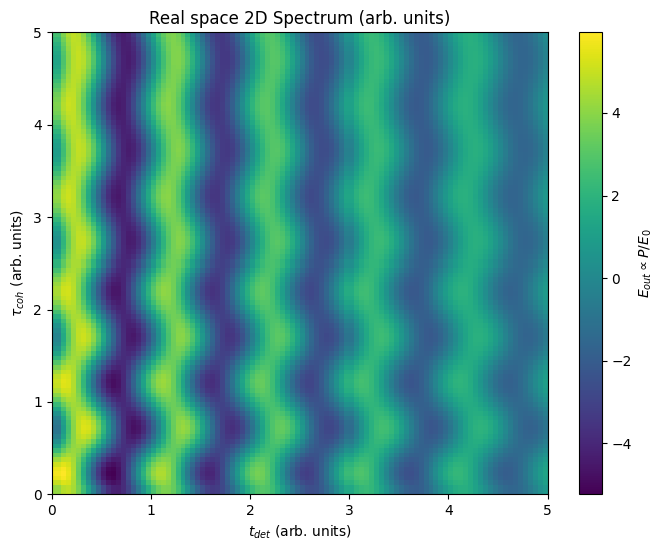

In [349]:
#
# CALCULATIONS
#
def compute_pulse(psiini, times, phi, i):
    args = {
        'phi': phi,
        'time': times[0] + Delta_ts[i],
        'omega': omegas[i],
        'Delta': Delta_ts[i],
        'E0': Omegas[i]
    }
    result = mesolve(H, psiini, times, c_ops=c_op_list, e_ops=e_op_list, args=args, options=options)
    return result
def compute_two_dimensional_polarization(T_val, phi_1, phi_2):
    times_0 = times
    tau_values, t_values = get_times_for_T(T_val)
    data = np.zeros((len(tau_values), len(t_values))) # x -> t, y -> tau

    data_1 = compute_pulse(psiini, times_0, phi_1, 0) # first pulse

    for tau_idx, tau in enumerate(tau_values):
        i = np.abs(tau_values[tau_idx] - (times_0 + Delta_ts[1] - Delta_ts[0])).argmin()  # find the index where T_val is
        while times[i] < 2 * Delta_ts[0]:
            i += 1

        psi_1 = data_1.states[i]  # Access psi_2 after waiting T

        times_1 = times[i:] - times[i]

        data_2 = compute_pulse(psi_1, times_1, phi_2, 1) # second pulse

        j = np.abs(T_val - (times_1 + Delta_ts[2] - Delta_ts[1])).argmin()  # find the index where T_val is
        while times_1[j] < 2 * Delta_ts[1]:
            j += 1

        psi_2 = data_2.states[j]  # Access psi_2 after waiting T
        times_2 = times[j:] - times[j]

        data_f = compute_pulse(psi_2, times_2, 0, 2) # third pulse

        for t_idx, t in enumerate(t_values):
            k = np.abs(t_values[t_idx] - (times_2 - Delta_ts[2])).argmin()  # find the closest index
            while times[k] < 2 * Delta_ts[2]:
                k += 1
            psi_f = data_f.states[k]  # Access psi_2 after waiting T

            # Compute the polarization and store it in the dictionary
            Polarization = expect(Dip_op, psi_f)
            data[tau_idx, t_idx] = Polarization

            if tau_idx == len(tau_values) // 1.1 and t_idx == len(t_values) // 1.1:
                # Combine and compute complete time and expectation values
                complete_time = np.concatenate([
                    times_0[:i],
                    times[i] + times_1[:j],
                    times[i] + times[j] + times_2
                ])
                complete_expect_1 = np.concatenate([
                    data_1.expect[0][:i],
                    data_2.expect[0][:j],
                    data_f.expect[0]
                ])
                complete_expect_2 = np.concatenate([
                    data_1.expect[1][:i],
                    data_2.expect[1][:j],
                    data_f.expect[1]
                ])


#                # Create the plot
#                plt.figure()
#                plt.plot(complete_time, complete_expect_1, label="$|g>$")
#                plt.plot(complete_time, complete_expect_2, label="$|e>$")
#
#                # Mark the specific time at `times[i]` and other relevant points within the smaller region
#                plt.axvline(times[0] + Delta_ts[0], linestyle=":", label=f"1. pulse starts at {times[0]:.0f}")
#                plt.axvline(times[i] + Delta_ts[1], linestyle=":", label=f"2. pulse starts at {times[i]:.2f}")
#                plt.axvline(times[i] + times_1[j] + Delta_ts[2], linestyle=":", label=f"3. pulse starts at {times[i] + times[j]:.2f}")
#                plt.axvline(times[i] + times[j] + times_2[k], linestyle=":", label=f"readout at ({times[i] + times[j] + times_2[k]:.2f})")
#
#                plt.xlabel("t")
#                plt.ylabel("Expectation Value")
#                plt.legend()
#                plt.grid()
#
#                margin =  .2
#                print(times_1[j])
#                time_min = times[i] + Delta_ts[1] - margin
#                time_max = times[i] + Delta_ts[1] + margin
#
#                # Filter the time and expectation data to only include values around `times[i]`
#                filtered_indices = (complete_time >= time_min) & (complete_time <= time_max)
#                filtered_time = complete_time[filtered_indices]
#                filtered_expect_1 = np.array(complete_expect_1)[filtered_indices]
#                filtered_expect_2 = np.array(complete_expect_2)[filtered_indices]
#
#                # Create the plot
#                plt.figure()
#                plt.plot(filtered_time, filtered_expect_1, label="$|g>$")
#                plt.plot(filtered_time, filtered_expect_2, label="$|e>$")
#
#                # Mark the specific time at `times[i]` and other relevant points within the smaller region
##                plt.axvline(times[0] + Delta_ts[0], linestyle=":", label=f"1. pulse starts at {times[0]:.0f}")
#                plt.axvline(times[i] + Delta_ts[1], linestyle=":", label=f"2. pulse starts at {times[i]:.2f}")
#                plt.axvline(times[i] + times_1[j] + Delta_ts[2], linestyle=":", label=f"3. pulse starts at {times[i] + times[j]:.2f}")
##                plt.axvline(times[i] + times[j] + times_2[k], linestyle=":", label=f"readout at ({times[i] + times[j] + times_2[k]:.2f})")
#
#                plt.xlabel("t")
#                plt.ylabel("Expectation Value")
#                plt.legend()
#                plt.grid()
#                plt.show()

    return tau_values, t_values, data

T_test = 0.0
data_test = compute_two_dimensional_polarization(T_test, phases[0], phases[0])
plot_positive_color_map(data_test[1], data_test[0], data_test[2], safe=False)

In [350]:
def process_phi_combination(phi_1, phi_2):
    # Preallocate an array to store results for each T in times_T
    data_array = np.empty((len(times_T) - 1), dtype=object)

    # Initialize variables for `max_taus` and `max_ts`
    max_taus, max_ts = None, None

    for i in range(0, len(times_T) - 1):
        data = compute_two_dimensional_polarization(times_T[i], phi_1, phi_2)

        # If this is the first iteration, store the shape of the first data
        if i == 0:
            max_taus = data[0]
            max_ts = data[1]
            max_shape_data = data[2].shape

        # Pad the data to match the max_shape
        padded_data = np.zeros(max_shape_data)  # Create an array of zeros with max_shape
        padded_data[:data[2].shape[0], :data[2].shape[1]] = data[2]  # Fill it with the current data

        # Store the padded data in the array
        data_array[i] = padded_data

    # Return the data array along with `max_taus` and `max_ts`
    return data_array, max_taus, max_ts

# Initialize results dictionary
all_results = {}
import itertools  # Importing itertools module

for phi1, phi2 in itertools.product(phases, phases):
    third_pulse_data, max_taus, max_ts = process_phi_combination(phi1, phi2)
    all_results[(phi1, phi2)] = {
        'third_pulse_data': third_pulse_data,
        'max_taus': max_taus,
        'max_ts': max_ts
    }

# The `all_results` dictionary now contains additional outputs `max_taus` and `max_ts`
# along with `third_pulse_data` keyed by `(phi1, phi2)`

In [351]:
# Initialize an array of None to accumulate the summed data for all i values
num_combinations = len(all_results)  # Total number of phase combinations
accumulated_data = None  # This will store the summed data for all `i` values

# Get the maximum number of T values (i.e., len(datas_for_phi_combination) for a single result)
num_time_values = len(next(iter(all_results.values()))['third_pulse_data'])
accumulated_data = [None] * num_time_values  # Initialize list to hold summed data for every `i`

# Iterate over all phase combinations in the `all_results` dictionary
for (phi1, phi2), result in all_results.items():
    # Get the `third_pulse_data` array for this combination
    datas_for_phi_combination = result['third_pulse_data']  # This is a list of arrays (one per time T value)

    # Iterate over each time index `i`
    for i in range(len(datas_for_phi_combination)):
        # If `accumulated_data[i]` is not initialized, set it to a zero array with the same shape as the data
        if accumulated_data[i] is None:
            accumulated_data[i] = np.zeros_like(datas_for_phi_combination[i])

        # Add the current data to the accumulated data for index `i`
        accumulated_data[i] += datas_for_phi_combination[i]

# Divide each accumulated data array by the number of combinations to calculate the average
averaged_data = [data / num_combinations for data in accumulated_data]

# `averaged_data` now holds the averaged third_pulse_data for each time index `i`
# Save the accumulated_data if needed

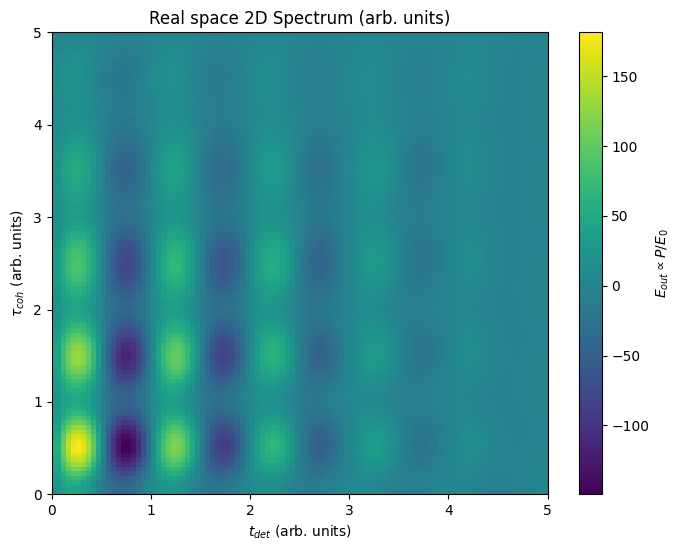

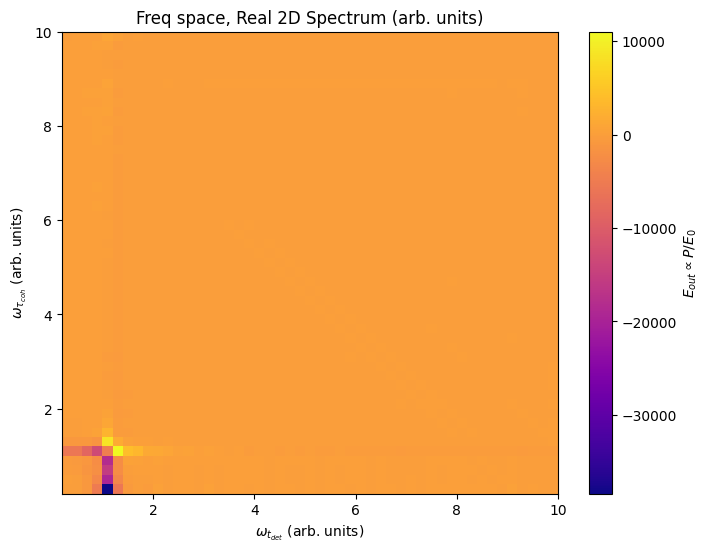

In [354]:
(phi_1, phi_2) = (phases[0],phases[0])
global_taus = all_results[(phi_1, phi_2)]['max_taus']
global_ts = all_results[(phi_1, phi_2)]['max_ts']
global_t_freqs = (np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0])))  # Frequency axis for detection time
global_tau_freqs = (np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0])))  # Frequency axis for excitation time
global_data_time = np.zeros((len(global_taus), len(global_ts)))
global_data_freq = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)

for i, data_time in enumerate(all_results[(phi_1, phi_2)]["third_pulse_data"]):  # Use enumerate to count iterations
#for i, data_time in enumerate(averaged_data):  # Use enumerate to count iterations
    data_extended_freq = np.fft.fft2(data_time)

    #plot_positive_color_map(global_ts, global_taus, data_time, times_T[i])
    #plot_positive_color_map(np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0])), np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0])), np.fft.fft2(data_time), times_T[i], space = "freq", type = "real", positive = True, safe = False)
    global_data_time += data_time
    global_data_freq += data_extended_freq

# Plot the aggregated results
plot_positive_color_map(global_ts, global_taus, global_data_time, safe=False) # Global time-space data
plot_positive_color_map(global_t_freqs, global_tau_freqs, (global_data_freq), space="freq", type="real", positive=True, safe=False) # Global frequency-space data

# Define the range for filtering
freq_range_min = -3
freq_range_max = 3

# Find indices for `global_t_freqs` and `global_tau_freqs` within 0 and 3
t_freq_indices = np.where((global_t_freqs >= freq_range_min) & (global_t_freqs <= freq_range_max))[0]
tau_freq_indices = np.where((global_tau_freqs >= freq_range_min) & (global_tau_freqs <= freq_range_max))[0]

# Filter the t and tau frequency axes
restricted_t_freqs = global_t_freqs[t_freq_indices]
restricted_tau_freqs = global_tau_freqs[tau_freq_indices]

# Filter the 2D data `global_data_freq` accordingly
restricted_data_freq = global_data_freq[np.ix_(tau_freq_indices, t_freq_indices)]
#plot_positive_color_map(restricted_t_freqs, restricted_tau_freqs, (restricted_data_freq), space="freq", type="real", positive=True, safe=False) # Global frequency-space data

In [ ]:
# Initialize the averaged_data_dict
averaged_data_dict = {}

# Collect all unique T_j values from all_results dictionary
# Iterate over unique T_j values
for T_j in times_T:
    averaged_data_dict = np.zeros_like(all_results[(phases[0], phases[0])]['third_pulse_data'])
    print(averaged_data_dict.shape)

    for (phi_1, phi_2) in all_results:
        averaged_data_dict += all_results[(phi_1, phi_2)]['third_pulse_data']

averaged_data_dict

In [ ]:
(phi_1, phi_2) = (phases[0],phases[0])
global_taus = all_results[(phi_1, phi_2)]['max_taus']
global_ts = all_results[(phi_1, phi_2)]['max_ts']
global_t_freqs = (np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0])))  # Frequency axis for detection time
global_tau_freqs = (np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0])))  # Frequency axis for excitation time
global_data_time = np.zeros((len(global_taus), len(global_ts)))
global_data_freq = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)

for i, data_time in enumerate(averaged_data_dict):  # Use enumerate to count iterations
#for i, data_time in enumerate(averaged_data):  # Use enumerate to count iterations
    data_extended_freq = np.fft.fft2(data_time)

    #plot_positive_color_map(global_ts, global_taus, data_time, times_T[i])
    #plot_positive_color_map(np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0])), np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0])), np.fft.fft2(data_time), times_T[i], space = "freq", type = "real", positive = True, safe = False)
    global_data_freq += data_extended_freq
    global_data_time += data_time

# Plot the aggregated results
plot_positive_color_map(global_ts, global_taus, global_data_time, safe=False) # Global time-space data
plot_positive_color_map(global_t_freqs, global_tau_freqs, (global_data_freq), space="freq", type="abs", positive=True, safe=False) # Global frequency-space data

# Define the range for filtering
freq_range_min = -3
freq_range_max = 3

# Find indices for `global_t_freqs` and `global_tau_freqs` within 0 and 3
t_freq_indices = np.where((global_t_freqs >= freq_range_min) & (global_t_freqs <= freq_range_max))[0]
tau_freq_indices = np.where((global_tau_freqs >= freq_range_min) & (global_tau_freqs <= freq_range_max))[0]

# Filter the t and tau frequency axes
restricted_t_freqs = global_t_freqs[t_freq_indices]
restricted_tau_freqs = global_tau_freqs[tau_freq_indices]

# Filter the 2D data `global_data_freq` accordingly
restricted_data_freq = global_data_freq[np.ix_(tau_freq_indices, t_freq_indices)]
plot_positive_color_map(restricted_t_freqs, restricted_tau_freqs, (restricted_data_freq), space="freq", type="real", positive=True, safe=False) # Global frequency-space data
